# Single Region Forecasting

## Data overview

The data provided in this competition/dataset consists of three parts:
1. Gridded weather forecasts over Sweden splitted in daily NetCDF files
2. Aggregate wind power production in the four different swedish price regions
3. A record of swedish wind turbines and their location.

The gridded weather forecasts are provided as 10 ensembles on a 71×169 projection coordinate grid centered over Sweden and contain the following variables:

|   Variable name  |               Long name               | Unit |
|:----------------:|:-------------------------------------:|:----:|
|    Temperature   |       Surface temperature (T2M)       |   K  |
|      Wind_U      |       Zonal 10 metre wind (U10M)      |  m/s |
|      Wind_V      |    Meridional 10 metre wind (V10M)    |  m/s |
|   WindGustSpeed  |               Wind gust               |  m/s |
|     Pressure     |     Mean Sea Level Pressure (MSLP)    |  Pa  |
| RelativeHumidity | Screen level relative humidity (RH2M) |   –  |
|    CloudCover    |        Total cloud cover (TCC)        |   –  |

Since every NetCDF file contains hourly values for one day (24 time steps) this means that the shape of the variables in each file is:

(time steps, height levels, ensembles, x_coordinates, y_coordinates) = (24, 1, 10, 169, 71)

The wind power production data is given as aggregates over each price region (SE1, SE2, SE3, SE4) in MWh/h. Since wind power capacity has grown over the course of the 24 months of competition data, we also provide you with a record of wind turbine installations. This record is quality check as good as we could but there might be discrepancies compared to reality. For example, according to the Swedish Wind Power Association there were 4099 wind turbines in Sweden constituting 8984 MW of installed capacity. In the record provided there are only 4004 wind turbines constituting 8640 MW of installed capacity. It is anticipated that the provided wind turbine record could be useful in understanding geographical clusters of wind turbines as well as the growth of installed capacity.

In the illustration below the wind turbines are plotted (left) as well as ten-to-one downsample version of the gridded NWP data (right).

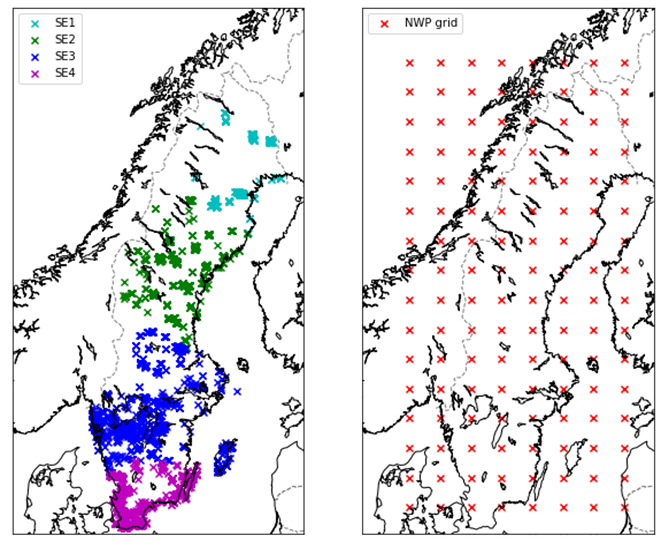

## Importing Libraries

In [1]:
import xarray as xr
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import math

import torch.nn as nn
import torch.nn.functional as F

import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import plotly
import plotly.express as px
import datetime

import plotly.graph_objects as go

In [2]:
from pathlib import Path
import sys

DIRPATH= str(Path.cwd().parents[1])

module_path = DIRPATH + "/src"
if module_path not in sys.path:
    sys.path.append(module_path)
from utils.eem2020 import (load_NWP, load_wind_power, 
                           load_max_power, load_turbine_map,
                           load_wind_power_TS, load_wind_turbines,
                           load_wind_power_SE, EarlyStopping,
                           special_split, PinBallLoss,
                           MAPE)

## Model

### Model param

In [11]:
lr = 5e-4
batch_size = 32
num_workers = 0
num_epochs = 1000
WANDB_ACTIVE = False

### Creating & Loading Dataset

In [4]:
class EEM20Dataset(Dataset):
    def __init__(self, start="20000101", end="20001231", SE="SE3", window=6, transform=None, testset=False,
                NWP_mean = None, NWP_std = None):
        """
        :param start: string start date (format: YYYYMMDD)
        :param end: string end date (format: YYYYMMDD)
        """
        self.window = window
        self.power_data = load_wind_power_SE(start=start, end=end, SE=SE)
        self.time = self.power_data.index
        self.power_data = np.array(self.power_data)
        self.max_power = load_max_power(start=start, end=end, SE=SE,SE1_adjusted=False)
        self.power_data_norm = self.power_data / self.max_power
    
        if not testset:
            self.NWP_data = xr.open_dataset(DIRPATH + "/data/eem20/processed/EEM2020_2000.nc")
        else:    
            self.NWP_data = load_NWP(start,end)
        self.NWP_data = self.NWP_data.assign(Wind=np.sqrt(self.NWP_data.Wind_U**2 + self.NWP_data.Wind_V**2))
        self.NWP_data = self.NWP_data.drop_vars(["Wind_U", "Wind_V","Temperature", "Pressure", "RelativeHumidity"])
        if NWP_mean is None:
            self.NWP_mean = self.NWP_data.mean()
            self.NWP_std = self.NWP_data.std()
        else:
            self.NWP_mean = NWP_mean
            self.NWP_std = NWP_std
        self.NWP_data = (self.NWP_data - self.NWP_mean) / self.NWP_std
        
        if SE=="SE1":
            self.X_data = self.NWP_data.isel(y=slice(92,156), x=slice(7,71))
            self.map_tur = load_turbine_map(start, end, "SE1", norm=True, SE1_adjusted=True)[:,92:156,7:]
            self.map_tur = xr.DataArray(np.repeat(self.map_tur, 24, axis=0), dims=["time","y","x"])
            self.X_data = self.X_data.assign(power=self.map_tur).to_array().transpose('time', 'variable', 'y', 'x')
        elif SE=="SE2":
            self.X_data = self.NWP_data.isel(y=slice(58,122), x=slice(7,71))
            self.map_tur = load_turbine_map(start, end, "SE2", norm=True)[:,58:122,7:71]
            self.map_tur = xr.DataArray(np.repeat(self.map_tur, 24, axis=0), dims=["time","y","x"])
            self.X_data = self.X_data.assign(power=self.map_tur).to_array().transpose('time', 'variable', 'y', 'x')
        elif SE=="SE3":
            self.X_data = self.NWP_data.isel(y=slice(14,78), x=slice(1,65))
            self.map_tur = load_turbine_map(start, end, "SE3", norm=True)[:,14:78,1:65]
            self.map_tur = xr.DataArray(np.repeat(self.map_tur, 24, axis=0), dims=["time","y","x"])
            self.X_data = self.X_data.assign(power=self.map_tur).to_array().transpose('time', 'variable', 'y', 'x')
        elif SE=="SE4":
            self.X_data = self.NWP_data.isel(y=slice(0,64), x=slice(0,64))
            self.map_tur = load_turbine_map(start, end, "SE4", norm=True)[:,0:64,0:64]
            self.map_tur = xr.DataArray(np.repeat(self.map_tur, 24, axis=0), dims=["time","y","x"])
            self.X_data = self.X_data.assign(power=self.map_tur).to_array().transpose('time', 'variable', 'y', 'x')
        self.start = start
        self.end = end
    
        
    
    def __len__(self):
        return len(self.power_data)
    
    def __getitem__(self, index):
        X = torch.tensor(self.X_data[index].values)
        y_norm = torch.tensor(self.power_data_norm[index])
        max_power = torch.tensor(self.max_power[index])
        hour = torch.tensor(self.time[index].hour)
        X, max_power, y_norm, hour = X.float(), max_power.float(), y_norm.float(), hour.float()
        return X, max_power, y_norm, hour

In [5]:
dataset = EEM20Dataset(start="20000101", end="20001231", SE="SE3")

In [6]:
train_set, val_set  = special_split(dataset, shift = 0)

In [7]:
loader_train = DataLoader(dataset = train_set, 
                          batch_size = batch_size,
                          shuffle=True,
                          num_workers=num_workers, drop_last=True)
loader_val = DataLoader(dataset = val_set,
                        batch_size = batch_size,
                        shuffle=False,
                        num_workers=num_workers, drop_last=True)

### Training Model

In [8]:
from models.vggbased import VGG

In [9]:
device = torch.device('cpu')
# model = torch.load("models/VGG7_SE3_16_32_2000.pt").to(device)
model = VGG(nb_input_channels=3).to(device)

In [10]:
criterion = nn.L1Loss()
early_stopping = EarlyStopping(patience=25)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
sum(p.numel() for p in model.parameters() if p.requires_grad)

774577

In [12]:
import wandb

config = {
  "learning_rate": lr,
  "epochs": num_epochs,
  "batch_size": batch_size,
  "ealy_stopping_patience": early_stopping.patience
}

if WANDB_ACTIVE:
  wandb.init(project="project-wind", entity="jejonker", config=config)
  wandb.watch(model)

In [ ]:
total_step = len(loader_train)
for epoch in range(0,num_epochs):
    running_loss = 0.0
    running_mape = 0.0
    model.train()
    for i, (X, max_power, y_norm,_) in enumerate(loader_train):
        X = X.to(device)
        max_power = max_power.to(device)
        y_norm = y_norm.reshape((len(y_norm),1)).to(device)
        
        out = model(X)
        loss = criterion(out*max_power,y_norm*max_power)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_mape += MAPE(out,y_norm).item()
    
    running_loss /= len(loader_train)
    running_mape /= len(loader_train)
    print ('Epoch [{}/{}], Loss MAE: {:.4f}, Loss MAPE: {:.4f}' 
                   .format(epoch+1, num_epochs, running_loss, running_mape))
    val_loss = 0
    val_mape = 0
    model.eval()
    for i, (X, max_power, y_norm,_) in enumerate(loader_val):
        X = X.to(device)
        max_power = max_power.reshape((len(y_norm),1)).to(device)
        y_norm = y_norm.reshape((len(y_norm),1)).to(device)
        
        out = model(X)
        
        val_loss += criterion(out*max_power,y_norm*max_power).item()
        val_mape += MAPE(out,y_norm).item()
        
    val_loss /= len(loader_val)
    val_mape /= len(loader_val)
    print ('Epoch [{}/{}], Val Loss MAE: {:.4f}, Val Loss MAPE: {:.4f}' 
                   .format(epoch+1, num_epochs, val_loss, val_mape))
    early_stopping(val_loss, model)
    
    if WANDB_ACTIVE:
        wandb.log({"Training Loss":running_loss, "Validation Loss":val_loss}, step=epoch)
    
    if early_stopping.early_stop:
        if WANDB_ACTIVE:
            wandb.log({"Early Stopped Epoch: " :epoch})
        break

In [17]:
model.load_state_dict(torch.load("./best_weights.pt"))

<All keys matched successfully>

In [ ]:
torch.save(model, DIRPATH + "/models/VGG7_SE3_16_32_2000.pt")
if WANDB_ACTIVE:
    wandb.save(DIRPATH + "/models/VGG7_SE3_16_32_2000.pt")

In [22]:
model.eval();

In [23]:
SE_task = "SE3"

In [24]:
def compute_loss(data_loader):
    loss = 0
    loss_MAPE = 0
    for i, (X, max_power, y_norm,_) in enumerate(data_loader):
        X = X.to(device)
        max_power = max_power.to(device)
        y_norm = y_norm.reshape((len(y_norm),1)).to(device)
            
        out = model(X)
        
        loss += criterion(out*max_power,y_norm*max_power).item()
        loss_MAPE += MAPE(out,y_norm).item()
        
    loss /= len(data_loader)
    loss_MAPE /= len(data_loader)
    
    return loss, loss_MAPE

In [25]:
dataset_task1 = EEM20Dataset(start="20010101",end="20010228",testset=True, NWP_mean = dataset.NWP_mean, NWP_std = dataset.NWP_std, SE=SE_task)

In [26]:
loader_task1 = DataLoader(dataset = dataset_task1,
                        batch_size = 1,
                        shuffle=False,
                        num_workers=num_workers)

In [27]:
loss, loss_MAPE = compute_loss(loader_task1)
print(loss)
print(loss_MAPE)
if WANDB_ACTIVE:
    wandb.log({"Test loss task1": loss})

143.1531867415218
0.24825961074064787


In [28]:
dataset_task2 = EEM20Dataset(start="20010301",end="20010430",testset=True, NWP_mean = dataset.NWP_mean, NWP_std = dataset.NWP_std, SE=SE_task)

In [29]:
loader_task2 = DataLoader(dataset = dataset_task2,
                        batch_size = 1,
                        shuffle=True,
                        num_workers=num_workers)

In [30]:
loss, loss_MAPE = compute_loss(loader_task2)
print(loss)
print(loss_MAPE)
if WANDB_ACTIVE:
    wandb.log({"Test loss task2": loss})

141.11802531135538
0.26145947416946913


In [31]:
dataset_task3 = EEM20Dataset(start="20010501",end="20010630",testset=True, NWP_mean = dataset.NWP_mean, NWP_std = dataset.NWP_std, SE=SE_task)

In [32]:
loader_task3 = DataLoader(dataset = dataset_task3,
                        batch_size = 1,
                        shuffle=True,
                        num_workers=num_workers)

In [33]:
loss, loss_MAPE = compute_loss(loader_task3)
print(loss)
print(loss_MAPE)
if WANDB_ACTIVE:
    wandb.log({"Test loss task3": loss})

118.86652888756632
0.2451379674267265


In [34]:
dataset_task4 = EEM20Dataset(start="20010701",end="20010831",testset=True, NWP_mean = dataset.NWP_mean, NWP_std = dataset.NWP_std, SE=SE_task)

In [35]:
loader_task4 = DataLoader(dataset = dataset_task4,
                        batch_size = 1,
                        shuffle=True,
                        num_workers=num_workers)

In [36]:
loss, loss_MAPE = compute_loss(loader_task4)
print(loss)
print(loss_MAPE)
if WANDB_ACTIVE:
    wandb.log({"Test loss task4": loss})

100.94196236605853
0.37879570037411775


In [37]:
dataset_task5 = EEM20Dataset(start="20010901",end="20011031",testset=True, NWP_mean = dataset.NWP_mean, NWP_std = dataset.NWP_std, SE=SE_task)

In [38]:
loader_task5 = DataLoader(dataset = dataset_task5,
                        batch_size = 1,
                        shuffle=True,
                        num_workers=num_workers)

In [39]:
loss, loss_MAPE = compute_loss(loader_task5)
print(loss)
print(loss_MAPE)
if WANDB_ACTIVE:
    wandb.log({"Test loss task5": loss})

136.56208041196314
0.2581947734850404


In [40]:
dataset_task6 = EEM20Dataset(start="20011101",end="20011231",testset=True, NWP_mean = dataset.NWP_mean, NWP_std = dataset.NWP_std, SE=SE_task)

In [41]:
loader_task6 = DataLoader(dataset = dataset_task6,
                        batch_size = 1,
                        shuffle=True,
                        num_workers=num_workers)

In [42]:
loss, loss_MAPE = compute_loss(loader_task6)
print(loss)
print(loss_MAPE)
if WANDB_ACTIVE:
    wandb.log({"Test loss task6": loss})

137.5561601842036
0.26410839572419886


In [ ]:
if WANDB_ACTIVE:
    wandb.finish()